In [1]:
from src.utils import prepare_dateframe
from src.config import config

## Анализ данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
analyze_df = pd.read_csv(config.data_path)

In [11]:
click_dict = dict(zip(*np.unique(analyze_df.clicks.values, return_counts=True)))

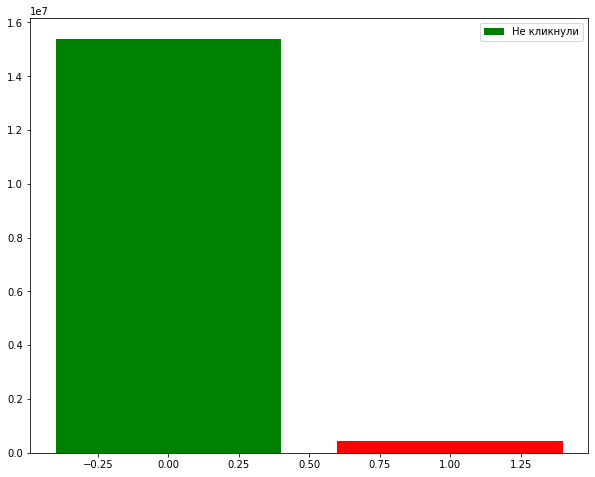

In [28]:
plt.figure(figsize=(10, 8))
plt.bar(click_dict.keys(), click_dict.values(), color=['g', 'r'])
plt.legend(['Не кликнули', 'Кликнули'])

Здесь мы видим явное преобладание тех, кто не кликнул над теми, кто это сделал, в целом логично, люди редко кликают в баннер.

Дальше сразу бросается в глаза, то, что есть такая "чудная" колонка как показ(impressions). В целом еще до тренировки модели, я могу сказать, что нет показа -> нет клика, хорошая фича, однако полезная ли?

In [32]:
print(np.unique(analyze_df.impressions))

[1]


Как видим в данном столбце значения только единичные. Поэтому этот параметр можно удалять сразу, потому-что ничего полезного он в себе не несет

Дальше давайте посмотрим на пропуски

In [35]:
analyze_df.isna().sum()

date_time              0
zone_id                0
banner_id              0
oaid_hash              0
campaign_clicks        0
os_id                  0
country_id             0
banner_id0             0
rate0                 69
g0                    69
coeff_sum0            69
banner_id1             0
rate1              19744
g1                 19744
coeff_sum1         19744
impressions            0
clicks                 0
dtype: int64

Cразу видно, что пропуски присутствуют только в тех значениях, которыми нам сказали в рамках этой дз не использовать. Нам же лучше, не надо думать каким образом эти данные заполнять

Дальше давайте посмотрим сколько вообще в каждом столбце уникальных значений. Предварительно наконец удалив "лишние" параметры

In [37]:
analyze_df.drop([
        'oaid_hash',
        'banner_id0',
        'banner_id1',
        'rate0',
        'rate1',
        'g0',
        'g1',
        'coeff_sum0',
        'coeff_sum1'
], inplace=True, axis=1)

Естественно, что мы не будем смотреть на уникальность значения в столбце дата, с ним мы разберемся позже.

In [40]:
for column in set(analyze_df.columns) - {'date_time'}:
    print(f"{column}, unique value length = {len(np.unique(analyze_df[column]))}")

os_id, unique value length = 11
clicks, unique value length = 2
zone_id, unique value length = 3444
banner_id, unique value length = 1633
campaign_clicks, unique value length = 822
impressions, unique value length = 1
country_id, unique value length = 17


Смотря на эти числа возникает желание объединить zone_id, banner_id и тд в более крупные группы. Но погуглив, не нахожу ничего, чтобы могло мне в этом помочь. От идеи отказываюсь 

Единственная в данном случае не категорильная фича - campaign_clicks. Давайте рассмотрим ее поподробнее

In [64]:
np.sum(analyze_df.campaign_clicks == 0) / len(analyze_df)

0.8648027187356524

In [66]:
np.quantile(analyze_df.campaign_clicks.values, 0.99)

7.0

In [67]:
np.max(analyze_df.campaign_clicks)

829

Что мы видим? В 86% случаев значение в целом 0. 0.99 квантиль 0.7, при этом максимум 829. Может возникнуть желание как-то разбить этот параметр, но от этой идеи тоже отказываюсь. Из-за того, что мы не смогли раздобыть осмысленного описания фичей  banner_id, zone_id. Группировка значения в 5 раз меньшего, вряд ли имеет особый смысл.

Итак, что мы видим? Параметры, которые нами почти не описываются, бесполезный параметр impression, + одно числовое значение campaign_clicks. Нам надо выдумывать фичи, однако перед этим нам надо как-то привести все параметры в таблице. Использовать One-hot нет никакого желания. Данных итак много и мне приходится их сэмплировать, чтобы не вылетала ошибка по памяти. Предлагаю заменить значения в таблице средней вероятностью клика при параметре. Пример: country_id = 2 мы заменим числом, которое отображает кол-во кликнувших в стране с country_id равным 2 на количество всех представителей страны с country_id равным 2.

Также мы видим, что фичей мало и мы хотим добавить еще фичей. Давайте перед этим разобьем параметры на те, которые относятся к юзеру и на те, которые относятся к рекламе.

Для удобства распечатаем их еще раз

In [69]:
analyze_df.columns

Index(['date_time', 'zone_id', 'banner_id', 'campaign_clicks', 'os_id',
       'country_id', 'impressions', 'clicks'],
      dtype='object')

Давайте начнем с очевидного, таргет - clicks. Удаляем - impressions.

Относятся к игроку:

    - campaign_clicks (число показов юзеру)
    
    - country_id (страна из которой юзер)
    
    - os_id (ОС юзера)

Относятся к баннеру:

    - zone_id (место нахождения баннера)
    
    - banner_id (че за баннер то вообще)
    
Что сразу бросается в глаза? Мы нигде не использовали date_time. Во-первых мы будем использовать этот параметр для разбиения, как мы помним из задания, мы должны провалидировать нашу модель на последнем дне из датасета. Я предлагаю вытащить еще такие параметры как час и день недели. Можно придумать очень много жизненных примеров про то, что  вероятность клика зависит от времени суток или дня недели, например в 19 вечера по будням, мы вероятнее в метро, чем в 19 вечера воскресенья, а в метро мы не любим ходить по ссылкам, так как интернет слабый. Таких примеров много, мы на них останавливаться не будем, просто будем чувствовать, что фича по времени может быть полезной - давайте ее оставим. И соответсвенно новые фичи, которые тоже относятся к юзеру:

    - hour
    - weekday

Теперь давайте на основе этих разбиений и каких-то наших знаниях о мире, нагенерим еще фичей.

Заполнять значения в таблице мы будем по тому же принципу, что и раньше, мы будем считать вероятность клика при выполнении условий, но теперь не одного, а несколько, например какова вероятность клика из страны с id 40 в воскресенье, это, кстати, в теории может быть важная фича, предполагаю, что траффик из Израиля по субботам например падает.

In [ ]:
{
    'features': ['hours', 'country_id'],
    'feature_name': 'per_hours_country',
},
{
    'features': ['os_id', 'country_id'],
    'feature_name': 'per_os_country',
},
{
    'features': ['weekday', 'hours'],
    'feature_name': 'per_weekday_hours',
},
{
    'features': ['weekday', 'country_id'],
    'feature_name': 'per_weekday_country',
},
{
    'features': ['weekday', 'country_id', 'hours'],
    'feature_name': 'per_weekday_country_hours',
},
pass

Сверху можно увидеть блок кода, но я хочу, чтобы вы воспринимали его как текст. Здесь суть отображены те фичи, которые я генерил парами. То есть выбирал все возможные пары и тройки и считал для них вероятности клика.

- hours и country_id я не нашел информации как сочетаются страные и часы, возможно все время записано в терминах Гринвича, поэтому добавил эту фичу, чтобы как-то развести страны по часовым поясам

- os_id, country_id предполагаю, что есть страны, с которых в основном течет траффик ботов, думаю, что os у этих ботов всегда +- одинаковая, поэтому решил добавить эту фичу, так как она может вероятно указать на того, кто перед нами

- weekday и hours в разные дни мы по разному пользуемся телефоном и интернетом

- weekday, country_id в разных странах разные выходны и будни, например Британцы если верить слухам, отдыхают вечером в четверг, а не по пятницам, мб после бара люди кликают в баннера чаще, а мб реже

- weekday, country_id, hours +- тоже самое, что предыдущая фича, но мб час улучшит ситуация

- zone_id и country_id в разных странах разных пользовательский опыт, кто-то всю дорогу пользовался вк, а кто-то фейсбуком, возможно мы привыкли смотреть в разные части экрана и как следствие замечать или нет баннера. Но(!) эту фичу я убрал по итогу, она мне честно нравилась, но с ней данные готовились бы час, а мне жалко того, кто будет запускать этот ноутбук

На этом анализ закончен, перехом к тренировке модели и оценке результатов

## Тренировка

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

### Читаем и "готовим" датасет (относительно долгий процесс). Для выполнения ДЗ использовал sample, потому-что не мог переварить весь объем данных 

In [4]:
train_df, test_df = prepare_dateframe(config)

Features in process:  50%|█████     | 6/12 [06:04<06:22, 63.80s/it]/home/stepankutsenogy/recsys_course/src/utils.py:32: RuntimeWarning: invalid value encountered in long_scalars
  transform_dict[values] = np.sum(tmp_df.clicks) / len(tmp_df)
Features in process: 100%|██████████| 12/12 [18:25<00:00, 92.14s/it] 


Отмечу сразу, что все параметры подбирал по валидации в процессе, когда делал дз, но так как задача стоит оценить модели на конкретном дне, здесь для краткости все эти моменты я опущу, скажу лишь, что в валидации данных с последнего дня не было. 

In [45]:
x_train = train_df.drop(['clicks'], axis=1)
y_train = train_df['clicks'].values

x_test = test_df.drop(['clicks'], axis=1)
y_test = test_df['clicks'].values

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [46]:
logreg = LogisticRegression(
    max_iter=5000,
    random_state=42,
)



linreg_grid_params = {
    'tol': [0, 1e-1, 1e-2, 1e-3, 1e-4],
    'C': [0, 0.5, 1, 2, 5],
    'class_weight': [None, 'balanced'],
}


logreg_random = RandomizedSearchCV(
    estimator=logreg,
    scoring='neg_log_loss',
    param_distributions = linreg_grid_params,
    n_iter=20,
    cv=3,
    verbose=10,
    random_state=config.random_state,
    n_jobs=-1,
)

In [47]:
logreg_random.fit(x_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/stepankutsenogy/MainWork/ltv_env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [-0.10905967 -0.59259745 -0.10905976 -0.59259753 -0.59259707 -0.59259753
 -0.59259733 -0.59259733 -0.10905976 -0.59259707 -0.10905967         nan
 -0.59259745         nan         nan         nan -0.10905977 -0.59259753
 -0.59259753 -0.59259707]
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=5000, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': [0, 0.5, 1, 2, 5],
                                        'class_weight': [None, 'balanced'],
                                        'tol': [0, 0.1, 0.01, 0.001, 0.0001]},
                   random_state=42, scoring='neg_log_loss', verbose=10)

In [50]:
log_loss(y_test, logreg_random.predict_proba(x_test)[:, 1])

0.13529389012325146

In [51]:
log_loss(y_test, [(1-y_train.mean(), y_train.mean())] * len(y_test))

0.1536656158996821

Я хочу отметить, что здесь мы "превзошли" тот критерий, который писали в чате, но признаться честно, мне она не очень нравится, давайте объясню почему, в целом как говорилось на лекции, задача рекомендации это во много задача ранжирования, те мы должны примеры правильно упорядочить, с упорядочением по аналогии приходит метрика roc_auc. Давайте лучше взглянем на нее.

In [55]:
roc_auc_score(y_test, logreg_random.predict_proba(x_test)[:, 1])

0.7686553017442452

Здесь мы видим, что 77% пар упорядоченно правильно. В целом, если подобрать порог, то получили "приемлимый" классификатор